In [10]:
import numpy as np
import pandas as pd
from math import floor, ceil
from numpy.linalg import cholesky, inv, solve 
from scipy.linalg import cho_solve
from scipy.stats import wishart, invwishart, gamma
from lifetimes import BetaGeoFitter, GammaGammaFitter
from lifetimes.utils import calibration_and_holdout_data, summary_data_from_transaction_data
from lifetimes.plotting import plot_calibration_purchases_vs_holdout_purchases, plot_period_transactions
from datetime import datetime, timedelta
import matplotlib.pyplot as plt

In [11]:
def load_dataset(datafile, parse_dates=None):
    df = pd.read_csv(datafile, delimiter=',', parse_dates=parse_dates)
    return df


## Implementation

In [6]:
# x ==> number of repeat purchases
# t ==> First purchase to last purchase
# T ==> First purchase to end of observation period


In [47]:
# Setup Regressors (Covariates) for location of 1st-stage prior, i.e. beta = [log(lambda), log(mu)]
def set_regressors(data, covariates=[]):
    data['intercept'] = 1.0
    covariates = ['intercept'] + covariates
    covars = np.matrix(data[covariates])
    K = len(covariates)
    return covariates, covars, K

def get_diag(shape, val):
    d = np.zeros(shape=shape)
    np.fill_diagonal(d, val) 
    return d

def get_map_from_array(x):
    a_map = {}
    count = 0
    for val in x:
        a_map[val] = count
        count += 1
    return a_map

# set hyper priors "log_lambda", "log_mu"
def set_hyperpriors(K):  
    beta_0 = np.zeros(shape=(K, 2))
    A_0 = get_diag(shape=(K, K), val=0.01) # diffuse precision matrix
    # set diffuse hyper-parameters for 2nd-stage prior of gamma_0; follows defaults from rmultireg example
    nu_00 = 3 + K  # 30
    gamma_00 = get_diag(shape=(2, 2), val=nu_00) # diffuse precision matrix
    hyper_prior = {'beta_0': beta_0, 'A_0':A_0, 'nu_00':nu_00, 'gamma_00':gamma_00}
    return hyper_prior

def draw_z(data, level_1, level_1_params_map):
    tx = data['t_cal']
    Tcal = data['T_cal']
    p_lambda = level_1[level_1_params_map['lambda'], ]
    p_mu = level_1[level_1_params_map['mu'], ]
    mu_lam = p_mu + p_lambda
    t_diff = Tcal - tx
    prob = 1 / (1 + (p_mu / mu_lam) * (np.exp(mu_lam * t_diff) - 1))
    z = (np.random.uniform(size=len(prob)) < prob)
    z[z == True] = 1
    z = z.astype(int)
    return list(z.values)

def draw_tau(data, level_1, level_1_params_map):
    N = len(data)
    tx = data['t_cal']
    Tcal = data['T_cal']
    p_lambda = level_1[level_1_params_map['lambda'], ]
    p_mu = level_1[level_1_params_map['mu'], ]

    mu_lam = p_mu + p_lambda
    z = level_1[level_1_params_map['z'], ]

    alive = (z == 1)
    tau = np.zeros(shape=(N))

    # Case: still alive - left truncated exponential distribution -> [T.cal, Inf]
    if (np.sum(alive) > 0):
        tau[alive] = Tcal[alive] + np.random.exponential(scale=1.0/p_mu[alive], size=np.sum(alive))

    # Case: churned - double truncated exponential distribution -> [tx, T.cal]
    if (np.sum(~alive) > 0):
        mu_lam_tx = np.minimum(700, mu_lam[~alive] * tx[~alive])
        mu_lam_Tcal = np.minimum(700, mu_lam[~alive] * Tcal[~alive])
        rand = np.random.uniform(size=np.sum(~alive))        
        tau[~alive] = (-1.0 * np.log((1.0 - rand) * np.exp(-1.0 * mu_lam_tx) + rand * np.exp((-1.0 * mu_lam_Tcal)))) / mu_lam[~alive]

    return tau

def chol2inv(chol):
    return cho_solve((chol, False), np.eye(chol.shape[0])) 

def draw_wishart(df, scale):
    W = wishart.rvs(df, scale)
    IW = inv(W)
    C = cholesky(W).T
    CI = inv(C)
    return W, IW, C, CI

def rmultireg(Y, X, Bbar, A, nu, V):
    # standard multi-variate normal regression update
    # Slide 33 in http://ice.uchicago.edu/2008_presentations/Rossi/ICE_tutorial_2008.pdf
    n = Y.shape[0]
    m = Y.shape[1]
    k = X.shape[1]    

    RA = cholesky(A)
    W = np.concatenate((X, RA), axis=0) 
    Z = np.concatenate((Y, RA*Bbar), axis=0)
    IR = solve(np.triu(cholesky(np.dot(W.T, W)).T), np.eye(k,k)) #trimatu interprets the matrix as upper triangular and makes solve more efficient
    Btilde = np.dot(np.dot(IR, IR.T), np.dot(W.T,Z))
    E = Z - np.dot(W, Btilde)
    S = np.dot(E.T, E)
    W, IW, C, CI = draw_wishart(df=nu+n, scale=chol2inv(cholesky(V+S).T))
    samples = np.random.normal(size=k*m).reshape(k,m)
    B = Btilde + np.dot(IR, np.dot(samples, CI.T))
    return {'beta': B.T, 'gamma':IW}

def draw_level_2(covars, level_1, level_1_params_map, hyper_prior):
    # standard multi-variate normal regression update
    Y = np.log(level_1[[level_1_params_map['lambda'], level_1_params_map['mu']],].T)
    X = covars
    Bbar = hyper_prior['beta_0']
    A = hyper_prior['A_0']
    nu = hyper_prior['nu_00']
    V = hyper_prior['gamma_00']
    
    return rmultireg(Y, X, Bbar, A, nu, V)

def log_post(log_theta, mvmean, x, z, Tcal, tau, inv_gamma):
    log_lambda = log_theta[0,:] 
    log_mu = log_theta[1,:]
    diff_theta = np.subtract(log_theta, mvmean.T)
    diff_lambda = diff_theta[0,:]
    diff_mu = diff_theta[1,:]
    likel = (x * log_lambda) + ((1 - z) * log_mu) - (((z * Tcal) + (1 - z) * tau) * (np.exp(log_lambda) + np.exp(log_mu)))
    prior = -0.5 * ((np.square(diff_lambda) * inv_gamma[0, 0]) + (2 * np.multiply(diff_lambda, diff_mu) * inv_gamma[0, 1]) + (np.square(diff_mu) * inv_gamma[1, 1]))
    post = np.add(likel[0], prior)    
    post[0,log_mu > 5] = np.NINF  # cap !!
    return post

def step(cur_log_theta, cur_post, gamma, N, mvmean, x, z, Tcal, tau, inv_gamma):
    new_log_theta = cur_log_theta + np.vstack((gamma[0, 0] * np.random.standard_t(df=3, size=N), gamma[1, 1] * np.random.standard_t(df=3, size=N)))
    new_log_theta[0,:] = np.maximum(np.minimum(new_log_theta[0,:], 70), -70)
    new_log_theta[1,:] = np.maximum(np.minimum(new_log_theta[1,:], 70), -70)
    new_post = log_post(new_log_theta, mvmean, x, z, Tcal, tau, inv_gamma)
    # accept/reject new proposal
    mhratio = np.exp(new_post - cur_post)
    unif = np.random.uniform(size=N)
    accepted = np.asarray(mhratio > unif)[0]
    cur_log_theta[:,accepted] = new_log_theta[:, accepted]
    cur_post[0,accepted] = new_post[0,accepted]
    return {'cur_log_theta':cur_log_theta, 'cur_post':cur_post}

def draw_level_1(data, covars, level_1, level_1_params_map, level_2):
    # sample (lambda, mu) given (z, tau, beta, gamma)
    N = len(data)
    x = data['x_cal']
    Tcal = data['T_cal']
    z = level_1[level_1_params_map['z'], ]
    tau = level_1[level_1_params_map['tau'], ]
    mvmean = np.dot(covars, level_2['beta'].T)
    gamma = level_2['gamma']
    inv_gamma = inv(gamma)
    
    cur_lambda = level_1[level_1_params_map['lambda'], ]
    cur_mu = level_1[level_1_params_map['mu'], ]

    # current state
    cur_log_theta = np.vstack((np.log(cur_lambda), np.log(cur_mu)))
    cur_post = log_post(cur_log_theta, mvmean, x, z, Tcal, tau, inv_gamma)
    
    iter = 1  # how high do we need to set this? 1/5/10/100?
    for i in range(0, iter):
        draw = step(cur_log_theta, cur_post, gamma, N, mvmean, x, z, Tcal, tau, inv_gamma)
        cur_log_theta = draw['cur_log_theta']
        cur_post = draw['cur_post']

    cur_theta = np.exp(cur_log_theta)

    return {'lambda':cur_theta[0,:], 'mu':cur_theta[1,:]}

def run_single_chain(data, covariates, K, hyper_prior, nsample, nburnin, nskip):
    ## initialize arrays for storing draws ##
    LOG_LAMBDA = 0
    LOG_MU = 1
    nr_of_cust = len(data)
    #nr_of_draws = nburnin + nsample * nskip
    nr_of_draws = nburnin + nsample

    # The 4 is for "lambda", "mu", "tau", "z"
    level_1_params_map = get_map_from_array(['lambda', 'mu', 'tau', 'z'])
    level_1_draws = np.zeros(shape=(nsample, 4, nr_of_cust))

    level_2_draws = np.zeros(shape=(nsample, (2*K)+3))
    nm = ['log_lambda', 'log_mu']
    if (K > 1):
        nm = ['{}_{}'.format(val2, val1) for val1 in covariates for val2 in nm]
    nm.extend(['var_log_lambda', 'cov_log_lambda_log_mu', 'var_log_mu'])
    level_2_params_map = get_map_from_array(nm)
        
    ## initialize parameters ##
    data['t_cal_tmp'] = data['t_cal']
    data['t_cal_tmp'][data.t_cal == 0] = data['T_cal'][data.t_cal == 0] 
    level_1 = level_1_draws[1,]
    x_cal_mean = np.mean(data['x_cal'])
    t_cal_tmp_mean = np.mean(data['t_cal_tmp'])
    level_1[level_1_params_map['lambda'], ] = x_cal_mean/t_cal_tmp_mean
    level_1[level_1_params_map['mu'], ] = 1 / (data['t_cal'] + 0.5 / level_1[level_1_params_map['lambda'], ])
    
    ## run MCMC chain ##
    hyper_prior['beta_0'][0, LOG_LAMBDA] = np.log(np.mean(level_1[level_1_params_map['lambda'], ]))
    hyper_prior['beta_0'][0, LOG_MU] = np.log(np.mean(level_1[level_1_params_map['mu'], ]))
    
    for i in range(0, nr_of_draws):
        # draw individual-level parameters
        level_1[level_1_params_map['z'], ] = draw_z(data, level_1, level_1_params_map)
        level_1[level_1_params_map['tau'], ] = draw_tau(data, level_1, level_1_params_map)

        level_2 = draw_level_2(covars, level_1, level_1_params_map, hyper_prior)
        draw = draw_level_1(data, covars, level_1, level_1_params_map, level_2)
        level_1[level_1_params_map['lambda'], ] = draw["lambda"]
        level_1[level_1_params_map['mu'], ] = draw["mu"]
        
        #nk = int(round((i - nburnin) / nskip))        
        if (i >= nburnin):
            #Store
            idx = i - nburnin
            level_1_draws[idx,:,:] = level_1 # nolint
            level_2_draws[idx,:] = list(np.array(level_2['beta'].T).reshape(-1)) + [level_2['gamma'][0, 0], level_2['gamma'][0, 1], level_2['gamma'][1,1]]
        if (i % 100) == 0:
            print('draw: {}'.format(i))
    coeff_mean = np.mean(level_2_draws, axis=0)
    coeff_stddev = np.std(level_2_draws, axis=0)    
    coeff = {}
    for param in level_2_params_map:
        coeff[param] = {}
        coeff[param]['mean'] = coeff_mean[level_2_params_map[param]]
        coeff[param]['stddev'] = coeff_stddev[level_2_params_map[param]]
    
    return {"level_1":level_1_draws, "level_1_params_map":level_1_params_map
          , "level_2":level_2_draws, "level_2_params_map":level_2_params_map
          , "coeff": coeff}    

####MCMC Functions
def get_correlation(draws):
    l2pmap = draws["level_2_params_map"]
    draw_means = np.mean(draws['level_2'], axis=0)
    corr = draw_means[l2pmap['cov_log_lambda_log_mu']]/(np.sqrt(draw_means[l2pmap['var_log_lambda']]) * np.sqrt(draw_means[l2pmap['var_log_mu']]))
    return corr

def get_nr_of_cust(draws):
    nr_of_cust = draws["level_1"].shape[2]
    return nr_of_cust

def PAlive(draws):
    l1pmap = draws["level_1_params_map"]
    nr_of_cust = get_nr_of_cust(draws)
    p_alive = np.mean(draws["level_1"][:,l1pmap['z'],:], axis=1)
    return p_alive

def draw_left_truncated_gamma(lower, k, lamda):
    pg = gamma.cdf(x=lower, a=k, scale=1.0/(k*lamda))
    rand = np.random.uniform(1, pg, 1)
    qg = gamma.ppf(q=rand, a=k, scale=1.0/(k*lamda))
    return qg

def DrawFutureTransactions(data, draws, sample_size=None):
    nr_of_draws = draws["level_2"].shape[0]
    if sample_size is not None:
            nr_of_draws = sample_size
    nr_of_cust = get_nr_of_cust(draws)
    parameters = draws["level_1_params_map"]
    x_holdout = np.zeros(shape=(nr_of_draws, nr_of_cust))
    t_cal = data['t_cal']
    T_holdout = data['T_holdout']
    T_cal = data['T_cal']

    for i in range(0, nr_of_cust):
        print('...processing customer: {} of {}'.format(i, nr_of_cust))
        Tcal = T_cal[i]
        Tholdout = T_holdout[i]
        tcal = t_cal[i]
        taus = draws['level_1'][:,parameters['tau'],i]
        ks = np.ones(shape=(len(taus)))    
        lamdas = draws['level_1'][:,parameters['lambda'],i]
        if sample_size is not None:
            taus = taus[sample_size]
            ks = ks[sample_size]
            lambdas = lambdas[sample_size]

        alive = taus > Tcal
        # Case: customer alive
        idx = 0
        for alive_val in alive:
            if alive_val:
                # sample itt which is larger than (Tcal-tx)
                itts = draw_left_truncated_gamma(Tcal - tcal, ks[idx], lamdas[idx])
                # sample 'sufficiently' large amount of inter-transaction times
                minT = np.minimum(Tcal + Tholdout - tcal, taus[idx] - tcal)
                nr_of_itt_draws = int(np.maximum(10, np.round(minT * lamdas[idx])))
                itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*2))))
                if (np.sum(itts) < minT):
                    itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*4))))
                if (np.sum(itts) < minT):
                    itts = np.hstack((itts, np.array(gamma.rvs(a=ks[idx], loc=ks[idx]*lamdas[idx], size=nr_of_itt_draws*800))))
                if (np.sum(itts) < minT):
                    print("...not enough inter-transaction times sampled! cust: {}, draw: {}, {} < {}".format(i, idx, np.sum(itts), minT))
                x_holdout[idx, i] = np.sum(np.cumsum(itts) < minT)
            idx += 1
        if (np.any(~alive)):
            x_holdout[~alive, i] = 0
    return x_holdout

def PActive(x_holdout_draws):
    nr_of_cust = x_holdout_draws.shape[1]
    p_alive = np.zeros(shape=(nr_of_cust))    
    for i in range(0, nr_of_cust):
        cd = x_holdout_draws[:,i]
        p_alive[i] = np.mean(cd[cd > 0])
    return p_alive



In [48]:
# Main routine
parse_dates = ['first']
g_cbs_dataset = '{}/cbs.csv'.format(g_datafolder)
df = load_dataset(g_cbs_dataset, parse_dates=parse_dates)
covariates, covars, K = set_regressors(df, covariates=["first_sales"])
hyper_prior = set_hyperpriors(K)
draws = run_single_chain(df, covariates=covariates, K=K, hyper_prior=hyper_prior, nsample=500, nburnin=500, nskip=10)
#x_holdout_draws = DrawFutureTransactions(df, draws, sample_size=None)
#df['x_predicted'] = np.mean(x_holdout_draws, axis=0)
#p_alive = PActive(x_holdout_draws)
#df['palive'] = p_alive


draw: 0
draw: 100
draw: 200


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 300


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 400


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 500


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 600


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 700


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 800


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:39: RuntimeWarning: overflow encountered in exp
/opt/conda/lib/pyth

draw: 900
draw: 1000
draw: 1100


In [49]:
draws['coeff']

{'log_lambda_intercept': {'mean': -3.2354884836790827,
  'stddev': 0.002954240458709289},
 'log_mu_intercept': {'mean': -10.991792869936848,
  'stddev': 0.44050501497817096},
 'log_lambda_first_sales': {'mean': 0.06497655440131367,
  'stddev': 0.06645011324058779},
 'log_mu_first_sales': {'mean': -15.153274537450008,
  'stddev': 6.670802600779097},
 'var_log_lambda': {'mean': 0.010116937609456764,
  'stddev': 0.001937462940773734},
 'cov_log_lambda_log_mu': {'mean': 0.00240570543954008,
  'stddev': 0.012226557237787887},
 'var_log_mu': {'mean': 10.676555831423103, 'stddev': 8.356392339223454}}

In [50]:
x_holdout_draws = DrawFutureTransactions(df, draws, sample_size=None)
df['x_predicted'] = np.mean(x_holdout_draws, axis=0)
p_alive = PActive(x_holdout_draws)
df['palive'] = p_alive

...processing customer: 0 of 2357
...processing customer: 1 of 2357
...processing customer: 2 of 2357
...processing customer: 3 of 2357
...processing customer: 4 of 2357
...processing customer: 5 of 2357
...processing customer: 6 of 2357
...processing customer: 7 of 2357
...processing customer: 8 of 2357
...processing customer: 9 of 2357
...processing customer: 10 of 2357
...processing customer: 11 of 2357
...processing customer: 12 of 2357
...processing customer: 13 of 2357
...processing customer: 14 of 2357
...processing customer: 15 of 2357
...processing customer: 16 of 2357
...processing customer: 17 of 2357
...processing customer: 18 of 2357
...processing customer: 19 of 2357
...processing customer: 20 of 2357
...processing customer: 21 of 2357
...processing customer: 22 of 2357
...processing customer: 23 of 2357
...processing customer: 24 of 2357
...processing customer: 25 of 2357
...processing customer: 26 of 2357
...processing customer: 27 of 2357
...processing customer: 28 of 

...processing customer: 231 of 2357
...processing customer: 232 of 2357
...processing customer: 233 of 2357
...processing customer: 234 of 2357
...processing customer: 235 of 2357
...processing customer: 236 of 2357
...processing customer: 237 of 2357
...processing customer: 238 of 2357
...processing customer: 239 of 2357
...processing customer: 240 of 2357
...processing customer: 241 of 2357
...processing customer: 242 of 2357
...processing customer: 243 of 2357
...processing customer: 244 of 2357
...processing customer: 245 of 2357
...processing customer: 246 of 2357
...processing customer: 247 of 2357
...processing customer: 248 of 2357
...processing customer: 249 of 2357
...processing customer: 250 of 2357
...processing customer: 251 of 2357
...processing customer: 252 of 2357
...processing customer: 253 of 2357
...processing customer: 254 of 2357
...processing customer: 255 of 2357
...processing customer: 256 of 2357
...processing customer: 257 of 2357
...processing customer: 258 

...processing customer: 459 of 2357
...processing customer: 460 of 2357
...processing customer: 461 of 2357
...processing customer: 462 of 2357
...processing customer: 463 of 2357
...processing customer: 464 of 2357
...processing customer: 465 of 2357
...processing customer: 466 of 2357
...processing customer: 467 of 2357
...processing customer: 468 of 2357
...processing customer: 469 of 2357
...processing customer: 470 of 2357
...processing customer: 471 of 2357
...processing customer: 472 of 2357
...processing customer: 473 of 2357
...processing customer: 474 of 2357
...processing customer: 475 of 2357
...processing customer: 476 of 2357
...processing customer: 477 of 2357
...processing customer: 478 of 2357
...processing customer: 479 of 2357
...processing customer: 480 of 2357
...processing customer: 481 of 2357
...processing customer: 482 of 2357
...processing customer: 483 of 2357
...processing customer: 484 of 2357
...processing customer: 485 of 2357
...processing customer: 486 

...processing customer: 687 of 2357
...processing customer: 688 of 2357
...processing customer: 689 of 2357
...processing customer: 690 of 2357
...processing customer: 691 of 2357
...processing customer: 692 of 2357
...processing customer: 693 of 2357
...processing customer: 694 of 2357
...processing customer: 695 of 2357
...processing customer: 696 of 2357
...processing customer: 697 of 2357
...processing customer: 698 of 2357
...processing customer: 699 of 2357
...processing customer: 700 of 2357
...processing customer: 701 of 2357
...processing customer: 702 of 2357
...processing customer: 703 of 2357
...processing customer: 704 of 2357
...processing customer: 705 of 2357
...processing customer: 706 of 2357
...processing customer: 707 of 2357
...processing customer: 708 of 2357
...processing customer: 709 of 2357
...processing customer: 710 of 2357
...processing customer: 711 of 2357
...processing customer: 712 of 2357
...processing customer: 713 of 2357
...processing customer: 714 

...processing customer: 915 of 2357
...processing customer: 916 of 2357
...processing customer: 917 of 2357
...processing customer: 918 of 2357
...processing customer: 919 of 2357
...processing customer: 920 of 2357
...processing customer: 921 of 2357
...processing customer: 922 of 2357
...processing customer: 923 of 2357
...processing customer: 924 of 2357
...processing customer: 925 of 2357
...processing customer: 926 of 2357
...processing customer: 927 of 2357
...processing customer: 928 of 2357
...processing customer: 929 of 2357
...processing customer: 930 of 2357
...processing customer: 931 of 2357
...processing customer: 932 of 2357
...processing customer: 933 of 2357
...processing customer: 934 of 2357
...processing customer: 935 of 2357
...processing customer: 936 of 2357
...processing customer: 937 of 2357
...processing customer: 938 of 2357
...processing customer: 939 of 2357
...processing customer: 940 of 2357
...processing customer: 941 of 2357
...processing customer: 942 

...processing customer: 1139 of 2357
...processing customer: 1140 of 2357
...processing customer: 1141 of 2357
...processing customer: 1142 of 2357
...processing customer: 1143 of 2357
...processing customer: 1144 of 2357
...processing customer: 1145 of 2357
...processing customer: 1146 of 2357
...processing customer: 1147 of 2357
...processing customer: 1148 of 2357
...processing customer: 1149 of 2357
...processing customer: 1150 of 2357
...processing customer: 1151 of 2357
...processing customer: 1152 of 2357
...processing customer: 1153 of 2357
...processing customer: 1154 of 2357
...processing customer: 1155 of 2357
...processing customer: 1156 of 2357
...processing customer: 1157 of 2357
...processing customer: 1158 of 2357
...processing customer: 1159 of 2357
...processing customer: 1160 of 2357
...processing customer: 1161 of 2357
...processing customer: 1162 of 2357
...processing customer: 1163 of 2357
...processing customer: 1164 of 2357
...processing customer: 1165 of 2357
.

...processing customer: 1361 of 2357
...processing customer: 1362 of 2357
...processing customer: 1363 of 2357
...processing customer: 1364 of 2357
...processing customer: 1365 of 2357
...processing customer: 1366 of 2357
...processing customer: 1367 of 2357
...processing customer: 1368 of 2357
...processing customer: 1369 of 2357
...processing customer: 1370 of 2357
...processing customer: 1371 of 2357
...processing customer: 1372 of 2357
...processing customer: 1373 of 2357
...processing customer: 1374 of 2357
...processing customer: 1375 of 2357
...processing customer: 1376 of 2357
...processing customer: 1377 of 2357
...processing customer: 1378 of 2357
...processing customer: 1379 of 2357
...processing customer: 1380 of 2357
...processing customer: 1381 of 2357
...processing customer: 1382 of 2357
...processing customer: 1383 of 2357
...processing customer: 1384 of 2357
...processing customer: 1385 of 2357
...processing customer: 1386 of 2357
...processing customer: 1387 of 2357
.

...processing customer: 1583 of 2357
...processing customer: 1584 of 2357
...processing customer: 1585 of 2357
...processing customer: 1586 of 2357
...processing customer: 1587 of 2357
...processing customer: 1588 of 2357
...processing customer: 1589 of 2357
...processing customer: 1590 of 2357
...processing customer: 1591 of 2357
...processing customer: 1592 of 2357
...processing customer: 1593 of 2357
...processing customer: 1594 of 2357
...processing customer: 1595 of 2357
...processing customer: 1596 of 2357
...processing customer: 1597 of 2357
...processing customer: 1598 of 2357
...processing customer: 1599 of 2357
...processing customer: 1600 of 2357
...processing customer: 1601 of 2357
...processing customer: 1602 of 2357
...processing customer: 1603 of 2357
...processing customer: 1604 of 2357
...processing customer: 1605 of 2357
...processing customer: 1606 of 2357
...processing customer: 1607 of 2357
...processing customer: 1608 of 2357
...processing customer: 1609 of 2357
.

...processing customer: 1805 of 2357
...processing customer: 1806 of 2357
...processing customer: 1807 of 2357
...processing customer: 1808 of 2357
...processing customer: 1809 of 2357
...processing customer: 1810 of 2357
...processing customer: 1811 of 2357
...processing customer: 1812 of 2357
...processing customer: 1813 of 2357
...processing customer: 1814 of 2357
...processing customer: 1815 of 2357
...processing customer: 1816 of 2357
...processing customer: 1817 of 2357
...processing customer: 1818 of 2357
...processing customer: 1819 of 2357
...processing customer: 1820 of 2357
...processing customer: 1821 of 2357
...processing customer: 1822 of 2357
...processing customer: 1823 of 2357
...processing customer: 1824 of 2357
...processing customer: 1825 of 2357
...processing customer: 1826 of 2357
...processing customer: 1827 of 2357
...processing customer: 1828 of 2357
...processing customer: 1829 of 2357
...processing customer: 1830 of 2357
...processing customer: 1831 of 2357
.

...processing customer: 2027 of 2357
...processing customer: 2028 of 2357
...processing customer: 2029 of 2357
...processing customer: 2030 of 2357
...processing customer: 2031 of 2357
...processing customer: 2032 of 2357
...processing customer: 2033 of 2357
...processing customer: 2034 of 2357
...processing customer: 2035 of 2357
...processing customer: 2036 of 2357
...processing customer: 2037 of 2357
...processing customer: 2038 of 2357
...processing customer: 2039 of 2357
...processing customer: 2040 of 2357
...processing customer: 2041 of 2357
...processing customer: 2042 of 2357
...processing customer: 2043 of 2357
...processing customer: 2044 of 2357
...processing customer: 2045 of 2357
...processing customer: 2046 of 2357
...processing customer: 2047 of 2357
...processing customer: 2048 of 2357
...processing customer: 2049 of 2357
...processing customer: 2050 of 2357
...processing customer: 2051 of 2357
...processing customer: 2052 of 2357
...processing customer: 2053 of 2357
.

...processing customer: 2249 of 2357
...processing customer: 2250 of 2357
...processing customer: 2251 of 2357
...processing customer: 2252 of 2357
...processing customer: 2253 of 2357
...processing customer: 2254 of 2357
...processing customer: 2255 of 2357
...processing customer: 2256 of 2357
...processing customer: 2257 of 2357
...processing customer: 2258 of 2357
...processing customer: 2259 of 2357
...processing customer: 2260 of 2357
...processing customer: 2261 of 2357
...processing customer: 2262 of 2357
...processing customer: 2263 of 2357
...processing customer: 2264 of 2357
...processing customer: 2265 of 2357
...processing customer: 2266 of 2357
...processing customer: 2267 of 2357
...processing customer: 2268 of 2357
...processing customer: 2269 of 2357
...processing customer: 2270 of 2357
...processing customer: 2271 of 2357
...processing customer: 2272 of 2357
...processing customer: 2273 of 2357
...processing customer: 2274 of 2357
...processing customer: 2275 of 2357
.

In [51]:
df.head()

,cust,x_cal,t_cal,litt,sales,sales_cal,first,T_cal,T_holdout,x_holdout,sales_holdout,first_sales,intercept,t_cal_tmp,x_predicted,palive
0,4,2,30.428571,4.219508,74.02,44.69,1997-01-01,38.857143,39,1,26.48,0.02933,1.0,30.428571,18.112,24.608696
1,18,0,0.000000,0.000000,14.96,0.00,1997-01-04,38.428571,39,0,0.00,0.01496,1.0,38.428571,16.334,23.334286
2,21,1,1.714286,0.538997,75.11,11.77,1997-01-01,38.857143,39,0,0.00,0.06334,1.0,1.714286,18.246,24.007895
3,50,0,0.000000,0.000000,6.79,0.00,1997-01-01,38.857143,39,0,0.00,0.00679,1.0,38.857143,18.094,24.061170
4,60,0,0.000000,0.000000,21.75,0.00,1997-02-01,34.428571,39,0,0.00,0.02175,1.0,34.428571,16.644,23.642045


In [52]:
np.mean(df['x_holdout'] - df['x_predicted'])

-17.649552821383114

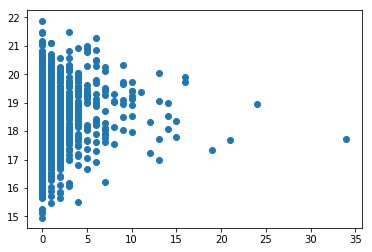

In [53]:
plt.scatter(df.x_holdout.values, df.x_predicted)

In [54]:
df[['x_cal', 'x_holdout', 'x_predicted']].groupby(['x_cal']).mean()

,x_holdout,x_predicted
x_cal,,
0,0.236712,18.338140
1,0.697039,18.519544
2,1.392523,18.654019
3,1.560000,18.632080
4,2.532258,18.837581
5,2.947368,18.778211
6,3.862069,18.660897
7,4.913043,18.414783
8,3.714286,18.685714
